# Modeling - ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Load data

In [3]:
data = pd.read_csv('../data/interim/energy_weather_features_train.csv',index_col=0)

In [4]:
data.index = pd.DatetimeIndex(data.index).to_period('H')

In [5]:
data = data.sort_index()

In [6]:
data.head()

energy  humidity  pressure  temperature          weather  \
datetime                                                                      
2012-10-01 13:00  11426.0      71.0    1014.0   284.010000  overcast clouds   
2012-10-01 14:00  11522.0      70.0    1014.0   284.054691  overcast clouds   
2012-10-01 15:00  11574.0      70.0    1014.0   284.177412  overcast clouds   
2012-10-01 16:00  11489.0      70.0    1014.0   284.300133  overcast clouds   
2012-10-01 17:00  11309.0      69.0    1014.0   284.422855  overcast clouds   

                  wind_direction  wind_speed  weather_broken clouds  \
datetime                                                              
2012-10-01 13:00             0.0         0.0                      0   
2012-10-01 14:00             0.0         0.0                      0   
2012-10-01 15:00             0.0         0.0                      0   
2012-10-01 16:00             0.0         0.0                      0   
2012-10-01 17:00             0.0         0.0                      0   

                  weather_drizzle  weather_few clouds  ...  \
datetime                                               ...   
2012-10-01 13:00                0                   0  ...   
2012-10-01 14:00                0                   0  ...   
2012-10-01 15:00                0                   0  ...   
2012-10-01 16:00                0                   0  ...   
2012-10-01 17:00                0                   0  ...   

                  weather_overcast clouds  weather_proximity thunderstorm  \
datetime                                                                    
2012-10-01 13:00                        1                               0   
2012-10-01 14:00                        1                               0   
2012-10-01 15:00                        1                               0   
2012-10-01 16:00                        1                               0   
2012-10-01 17:00                        1                               0   

                  weather_scattered clouds  weather_sky is clear  \
datetime                                                           
2012-10-01 13:00                         0                     0   
2012-10-01 14:00                         0                     0   
2012-10-01 15:00                         0                     0   
2012-10-01 16:00                         0                     0   
2012-10-01 17:00                         0                     0   

                  weather_snow  n_humidity  n_pressure  n_temperature  \
datetime                                                                
2012-10-01 13:00             0    0.681319   -0.546338       0.090982   
2012-10-01 14:00             0    0.670330   -0.546338       0.094994   
2012-10-01 15:00             0    0.670330   -0.546338       0.106013   
2012-10-01 16:00             0    0.670330   -0.546338       0.117033   
2012-10-01 17:00             0    0.659341   -0.546338       0.128052   

                  n_wind_direction  n_wind_speed  
datetime                                          
2012-10-01 13:00               0.0     -2.284797  
2012-10-01 14:00               0.0     -2.284797  
2012-10-01 15:00               0.0     -2.284797  
2012-10-01 16:00               0.0     -2.284797  
2012-10-01 17:00               0.0     -2.284797  

[5 rows x 30 columns]

In [7]:
data.index

PeriodIndex(['2012-10-01 13:00', '2012-10-01 14:00', '2012-10-01 15:00',
             '2012-10-01 16:00', '2012-10-01 17:00', '2012-10-01 18:00',
             '2012-10-01 19:00', '2012-10-01 20:00', '2012-10-01 21:00',
             '2012-10-01 22:00',
             ...
             '2016-12-31 14:00', '2016-12-31 15:00', '2016-12-31 16:00',
             '2016-12-31 17:00', '2016-12-31 18:00', '2016-12-31 19:00',
             '2016-12-31 20:00', '2016-12-31 21:00', '2016-12-31 22:00',
             '2016-12-31 23:00'],
            dtype='period[H]', name='datetime', length=35884, freq='H')

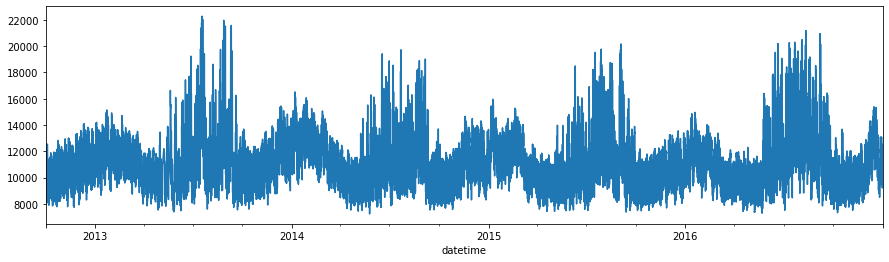

In [8]:
plt.figure(figsize=(15,4))
data['energy'].plot()
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(data['energy'])
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 6.064998008569807e-25


Since the p-value is extremely small, we can reject the null hypothesis that the data is a random walk.

# ARIMA Model

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

## Tune hyperparameters

Due to the large number of data points, we'll use only the year 2013 for tuning hyperparameters (p,q,d). The model is selected based on the Akaike's Information Criteria (AIC).

In [64]:
train_data = data.loc['2013'][['energy']]

ps = [0,1,2,3,4,5]
qs = [0,1,2,3,4,5]
ds = [0,1,2,3,4,5]
minaic = 10000000000
for p in ps:
    for q in qs:
        for d in ds:
            try:
                model = ARIMA(train_data, order=(p,q,d))
                result = model.fit()
                if result.aic < minaic:
                    minaic = result.aic
                    minbic = result.bic
                    optp = p
                    optq = q
                    optd = d
            except:
                continue
print(optp,optq,optd,minaic,minbic)

4 1 5 114800.36309588332 114877.35755052207


From the optimization above, the optimal p, q, and d are 4, 1, and 5. This means that the model only requres 4 lags in the historical data (4 hours), 1 degree of differencing to account for non-stationary (1 hour), and size 5 moving average window (5 hours).

## Plot predictions

Here, we check the model forcasts versus the real data.

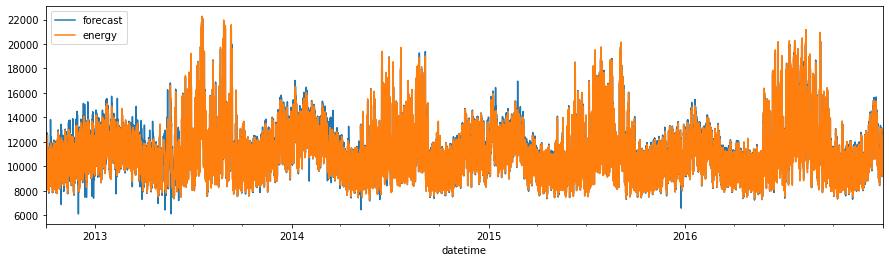

In [19]:
plt.rc("figure", figsize=(15,4))
model = ARIMA(data[['energy']], order=(4,1,5))
result = model.fit()
result.plot_predict(start='2012', end='2016')
plt.show()

In [20]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.energy   No. Observations:                35883
Model:                 ARIMA(4, 1, 5)   Log Likelihood             -250858.710
Method:                       css-mle   S.D. of innovations            262.967
Date:                Thu, 02 Dec 2021   AIC                         501739.420
Time:                        07:37:56   BIC                         501832.788
Sample:                    10-01-2012   HQIC                        501769.125
                         - 12-31-2016                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0215      1.768     -0.012      0.990      -3.486       3.443
ar.L1.D.energy     1.2068      0.019     63.281      0.000       1.169       1.244
ar.L2.D.energy     0.6597      0.018     36.638      0.000       0.624       0.695
ar.L3.D.energy    -1.2463      0.018    -70.912      0.000      -1.281      -1.212
ar.L4.D.energy     0.2843      0.019     15.122      0.000       0.247       0.321
ma.L1.D.energy    -0.4282      0.019    -22.215      0.000      -0.466      -0.390
ma.L2.D.energy    -1.2435      0.008   -163.784      0.000      -1.258      -1.229
ma.L3.D.energy     0.3681      0.028     13.170      0.000       0.313       0.423
ma.L4.D.energy     0.3113      0.008     36.863      0.000       0.295       0.328
ma.L5.D.energy     0.1139      0.011     10.192      0.000       0.092       0.136
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0033           -0.0000j            1.0033           -0.5000
AR.2            0.9759           -0.2612j            1.0102           -0.0416
AR.3            0.9759           +0.2612j            1.0102            0.0416
AR.4            3.4348           -0.0000j            3.4348           -0.0000
MA.1            1.0190           -0.2026j            1.0389           -0.0312
MA.2            1.0190           +0.2026j            1.0389            0.0312
MA.3           -1.0056           -0.0000j            1.0056           -0.5000
MA.4           -1.8828           -2.1319j            2.8443           -0.3651
MA.5           -1.8828           +2.1319j            2.8443            0.3651
-----------------------------------------------------------------------------
"""

# ARIMA Model + features

Here, we can add additional features (exogeneous variables) to our optimized ARIMA model. Recall that these additional features include data such as weather type, humidity, pressure, temperature, wind direction/speed.

## Plot predictions

In [26]:
features_predict = data.iloc[:,7:]

In [32]:
features_predict.head()

weather_broken clouds  weather_drizzle  weather_few clouds  \
datetime                                                                       
2012-10-01 13:00                      0                0                   0   
2012-10-01 14:00                      0                0                   0   
2012-10-01 15:00                      0                0                   0   
2012-10-01 16:00                      0                0                   0   
2012-10-01 17:00                      0                0                   0   

                  weather_fog  weather_haze  weather_heavy intensity rain  \
datetime                                                                    
2012-10-01 13:00            0             0                             0   
2012-10-01 14:00            0             0                             0   
2012-10-01 15:00            0             0                             0   
2012-10-01 16:00            0             0                             0   
2012-10-01 17:00            0             0                             0   

                  weather_heavy snow  weather_light intensity drizzle  \
datetime                                                                
2012-10-01 13:00                   0                                0   
2012-10-01 14:00                   0                                0   
2012-10-01 15:00                   0                                0   
2012-10-01 16:00                   0                                0   
2012-10-01 17:00                   0                                0   

                  weather_light rain  weather_light snow  ...  \
datetime                                                  ...   
2012-10-01 13:00                   0                   0  ...   
2012-10-01 14:00                   0                   0  ...   
2012-10-01 15:00                   0                   0  ...   
2012-10-01 16:00                   0                   0  ...   
2012-10-01 17:00                   0                   0  ...   

                  weather_overcast clouds  weather_proximity thunderstorm  \
datetime                                                                    
2012-10-01 13:00                        1                               0   
2012-10-01 14:00                        1                               0   
2012-10-01 15:00                        1                               0   
2012-10-01 16:00                        1                               0   
2012-10-01 17:00                        1                               0   

                  weather_scattered clouds  weather_sky is clear  \
datetime                                                           
2012-10-01 13:00                         0                     0   
2012-10-01 14:00                         0                     0   
2012-10-01 15:00                         0                     0   
2012-10-01 16:00                         0                     0   
2012-10-01 17:00                         0                     0   

                  weather_snow  n_humidity  n_pressure  n_temperature  \
datetime                                                                
2012-10-01 13:00             0    0.681319   -0.546338       0.090982   
2012-10-01 14:00             0    0.670330   -0.546338       0.094994   
2012-10-01 15:00             0    0.670330   -0.546338       0.106013   
2012-10-01 16:00             0    0.670330   -0.546338       0.117033   
2012-10-01 17:00             0    0.659341   -0.546338       0.128052   

                  n_wind_direction  n_wind_speed  
datetime                                          
2012-10-01 13:00               0.0     -2.284797  
2012-10-01 14:00               0.0     -2.284797  
2012-10-01 15:00               0.0     -2.284797  
2012-10-01 16:00               0.0     -2.284797  
2012-10-01 17:00               0.0     -2.284797  

[5 rows x 23 columns]

/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


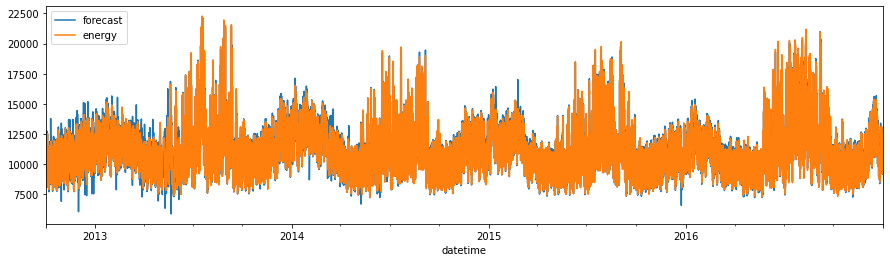

In [27]:
plt.rc("figure", figsize=(15,4))
model_x1 = ARIMA(data[['energy']], exog=features_predict, order=(4,1,5))
result_x1 = model_x1.fit()
result_x1.plot_predict(start='2012', end='2016')
plt.show()

In [28]:
result_x1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.energy   No. Observations:                35883
Model:                 ARIMA(4, 1, 5)   Log Likelihood             -251949.028
Method:                       css-mle   S.D. of innovations            271.081
Date:                Thu, 02 Dec 2021   AIC                         503966.056
Time:                        07:46:50   BIC                         504254.649
Sample:                    10-01-2012   HQIC                        504057.872
                         - 12-31-2016                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -7.023e+13        nan        nan        nan         nan         nan
weather_broken clouds            7.023e+13   3.58e+05   1.96e+08      0.000    7.02e+13    7.02e+13
weather_drizzle                  7.023e+13        nan        nan        nan         nan         nan
weather_few clouds               7.023e+13   5.04e+05   1.39e+08      0.000    7.02e+13    7.02e+13
weather_fog                      7.023e+13   1.01e+06   6.95e+07      0.000    7.02e+13    7.02e+13
weather_haze                     7.023e+13        nan        nan        nan         nan         nan
weather_heavy intensity rain     7.023e+13        nan        nan        nan         nan         nan
weather_heavy snow               7.023e+13   1.77e+06   3.97e+07      0.000    7.02e+13    7.02e+13
weather_light intensity drizzle  7.023e+13   1.75e+06      4e+07      0.000    7.02e+13    7.02e+13
weather_light rain               7.023e+13   3.78e+05   1.86e+08      0.000    7.02e+13    7.02e+13
weather_light snow               7.023e+13        nan        nan        nan         nan         nan
weather_mist                     7.023e+13   7.91e+05   8.88e+07      0.000    7.02e+13    7.02e+13
weather_moderate rain            7.023e+13   1.05e+06    6.7e+07      0.000    7.02e+13    7.02e+13
weather_other                    7.023e+13    9.1e+05   7.71e+07      0.000    7.02e+13    7.02e+13
weather_overcast clouds          7.023e+13   1.38e+06   5.09e+07      0.000    7.02e+13    7.02e+13
weather_proximity thunderstorm   7.023e+13        nan        nan        nan         nan         nan
weather_scattered clouds         7.023e+13   1.83e+06   3.84e+07      0.000    7.02e+13    7.02e+13
weather_sky is clear             7.023e+13   2.18e+06   3.22e+07      0.000    7.02e+13    7.02e+13
weather_snow                     7.023e+13        nan        nan        nan         nan         nan
n_humidity                        326.9426      5.215     62.694      0.000     316.722     337.164
n_pressure                         -1.9294      2.414     -0.799      0.424      -6.661       2.802
n_temperature                      19.7272      2.576      7.657      0.000      14.677      24.777
n_wind_direction                   94.1884      6.206     15.177      0.000      82.025     106.352
n_wind_speed                        4.4268      1.912      2.316      0.021       0.680       8.173
ar.L1.D.energy                      1.2768      0.017     75.006      0.000       1.243       1.310
ar.L2.D.energy                      0.6004      0.016     37.370      0.000       0.569       0.632
ar.L3.D.energy                     -1.3130      0.016    -83.356      0.000      -1.344      -1.282
ar.L4.D.energy                      0.3491      0.017     20.731      0.000       0.316       0.382
ma.L1.D.energy                     -0.4904      0.017    -28.216      0.000      -0.524      -0.456
ma.L2.D.energy                     -1.213

Comparing the ARIMA two models, the original model without additional features actually has lower AIC. Thus, including the weather data do not improve the performance.

Note that the coefficients for constant and categorical weather are similar, it means that the model simply did not used the categorical feature at all.

# Rolling Forecast - ARIMA

Next, we can try to quantify the RMSE for the next 100 hours into the future using rolling forcast technique.

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
train = data.loc['2013'][['energy']]
test = data.loc['2014'][['energy']]
features_train = data.loc['2013'].iloc[:,7:]
features_test = data.loc['2014'].iloc[:,7:]

In [131]:
myhistory = train[7000:]
predict_range = 100

mytrue = []
mypredict = []
for t in range(predict_range):
    f_model = ARIMA(myhistory, order=(4,1,5))
    f_model_fit = f_model.fit()
    forecast = f_model_fit.forecast()
    pred = forecast[0]    
    mypredict.append(pred)
    mytrue.append(test.iloc[t])
    myhistory = pd.concat([myhistory,test.iloc[[t]]])

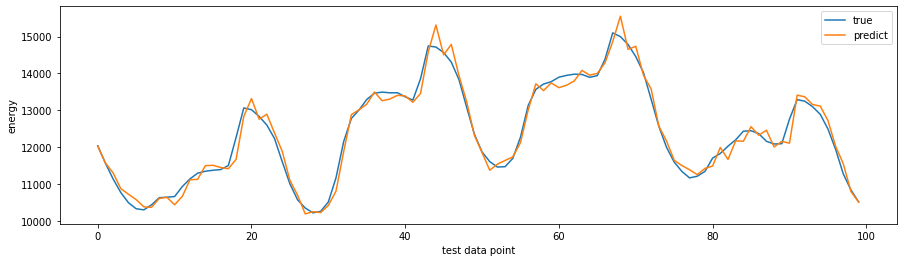

In [94]:
plt.plot(mytrue,label='true')
plt.plot(mypredict,label='predict')
plt.xlabel('test data point')
plt.ylabel('energy')
plt.legend()
plt.show()

In [96]:
rmse = np.sqrt(mean_squared_error(mytrue, mypredict))
print(rmse)

208.4620233727523


# Rolling Forecast - ARIMA with features

In [29]:
myhistory = train[7000:]
feature_history = features_train[7000:]

predict_range = 100
mytrue = []
mypredict = []
for t in range(predict_range):
    f_model = ARIMA(myhistory, exog=feature_history, order=(4,1,5))
    f_model_fit = f_model.fit()
    forecast = f_model_fit.forecast(exog=features_test.iloc[[t]])
    pred = forecast[0]    
    mypredict.append(pred)
    mytrue.append(test.iloc[t])
        
    myhistory = pd.concat([myhistory,test.iloc[[t]]])
    feature_history = pd.concat([feature_history,features_test.iloc[[t]]])

/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params avail

/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params avail

/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gritkupgan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


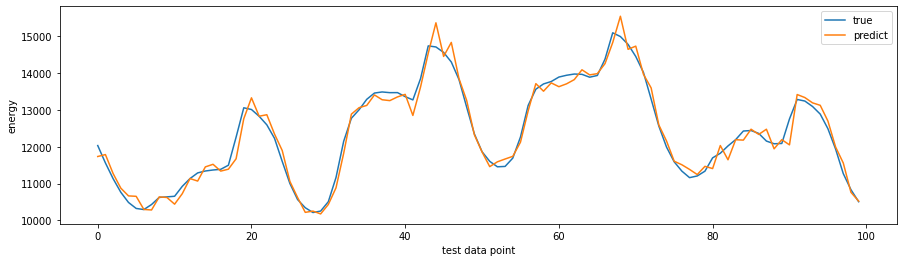

In [30]:
plt.plot(mytrue,label='true')
plt.plot(mypredict,label='predict')
plt.xlabel('test data point')
plt.ylabel('energy')
plt.legend()
plt.show()

In [31]:
rmse = np.sqrt(mean_squared_error(mytrue, mypredict))
print(rmse)

221.22095945105613


As expected based on the AIC, here we found that the RMSE is smaller for the model without additional weather features (i.e., 208.46 versus 221.22).